In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
import pandas as pd
import wrds
import matplotlib.pyplot as plt
import graphviz 

In [2]:
conn = wrds.Connection()

Loading library list...
Done


In [3]:
pd.set_option("display.max_columns", 500)

In [4]:
smccf= pd.read_csv("smccf.csv");


# US bonds Eligible for SMCCF;

In [6]:
# conn.list_tables(library='wrdsapps_link_crsp_bond')

# stmt="""
# select  a.complete_cusip as cusip_id, a.issuer_id, b.permno, b.link_startdt, b.link_enddt
# from fisd.fisd_mergedissue as a, wrdsapps_link_crsp_bond.bondcrsp_link as b
# where a.complete_cusip in {}
# and a.complete_cusip = b.cusip
# order by a.complete_cusip, b.link_enddt

# """.format(tuple(smccf['cusip'].unique()))

# bond = conn.raw_sql(stmt, date_cols=['link_startdt','link_enddt']);
# len(bond)

# bond.drop_duplicates(subset='cusip_id', keep='last', inplace=True);
# len(bond)
# bond.head(1)


# stmt="""
# select b.gvkey, b.lpermno::int as permno, b.liid as iid, b.linktype, b.linkprim, b.linkdt, b.linkenddt
# from crsp.ccmxpf_linktable as b
# where substr(b.linktype,1,1)='L'
# and (b.linkprim ='C' or b.linkprim='P')
# order by b.gvkey, b.linkenddt
# """

# ccp = conn.raw_sql(stmt, date_cols=['linkdt', 'linkenddt']);
# ccp['linkenddt']=ccp['linkenddt'].fillna(pd.to_datetime('today', format="%Y-%m-%d"))
# ccp.drop_duplicates(subset='gvkey', keep='last', inplace=True)
# ccp.head(1)


# stmt="""
# select a.*
# from 
# (select gvkey, fyear::int as year, at/1000 as at, capx/at as iy1,
# emp/at*1000 as emp,
# ppent/at as ppent, 
# ni/at as roa, (dltt+dlc)/at as debt_long,
# coalesce(SEQ, CEQ+PSTK, AT-LT) as book,
# prcc_c * csho as market,
# (coalesce(SEQ, CEQ+PSTK, AT-LT))/nullif(prcc_c * csho,0) as b2m,
# (DVC+DVP)/nullif(at,0) as dividend,
# (at + prcc_c * csho - ceq - txditc)/at as tobinq,
# (ib + dp)/at as cf,
# che/at as cash, 
# (dlc+dltt)/at as debt,
# sich as sic,
# sale
# from compa.funda
# where 
# indfmt='INDL' and datafmt='STD' and popsrc='D' and consol='C'
# and at>10
# and capx>0
# and ppent>0
# and che>0
# and sale>0
# and ppent<at
# and che<at
# and capx<at
# and fyear=2019
# and sich is not null
# ) as a
# """

# funda= conn.raw_sql(stmt)
# funda['sic']=funda['sic'].astype(int)
# funda['sic2']=funda['sic'].apply(lambda x:str(x)[:2])
# funda = pd.merge(funda, ccp[['gvkey', 'permno']], how='left', validate='one_to_one');
# funda.drop(index= funda[funda['permno'].isnull()].index, inplace=True);
# funda.drop(index= funda[funda['cf'].isnull()].index, inplace=True);
# funda.dropna(axis=1, inplace=True, how='any')

1136

In [10]:
funda.to_csv("funda.csv", index=False)

In [30]:
y = np.where(funda['permno'].isin(bond['permno'].unique()), 1, 0);
np.unique(y, return_counts=True)

(array([0, 1]), array([4122,  317]))

In [31]:
funda.columns.values

array(['gvkey', 'year', 'at', 'iy1', 'ppent', 'roa', 'book', 'cf', 'cash',
       'sic', 'sale', 'sic2', 'permno'], dtype=object)

In [32]:
varlist=[ 'at', 'ppent', 'roa', 'book', 'cf', 'cash','sale']

# funda2 = pd.merge(funda[varlist], pd.get_dummies(funda['sic2'], prefix='ind'), left_index=True, right_index=True);

In [33]:
# funda2.head(1)

In [34]:
funda[varlist].head(1)

at     ppent       roa   book        cf      cash    sale
0  2.079  0.210245  0.002116  902.6  0.032949  0.204281  2089.3

In [35]:
X_train, X_test, y_train, y_test = train_test_split(funda[varlist], y, test_size=0.2, random_state=4000, stratify=y);

In [36]:
skf = StratifiedKFold(n_splits=5, random_state=40, shuffle=True)
X_train.reset_index(drop=True, inplace=True)

In [37]:
funda.describe().transpose()

count          mean           std           min           25%  \
year    4439.0   2019.000000      0.000000   2019.000000   2019.000000   
at      4439.0     17.981394    112.347018      0.010031      0.249755   
iy1     4439.0      0.035422      0.049219      0.000002      0.006100   
ppent   4439.0      0.242914      0.254203      0.000004      0.047199   
roa     4439.0     -0.065884      0.300529     -4.197268     -0.063423   
book    4439.0   3534.486799  14525.623865 -11577.000000     67.104500   
cf      4439.0     -0.031572      0.293987     -3.998990     -0.021160   
cash    4439.0      0.197094      0.230734      0.000002      0.035563   
sic     4439.0   4764.623339   1969.195986    100.000000   2990.000000   
sale    4439.0   5703.676117  22629.089735      0.007000    102.092000   
permno  4439.0  49396.023429  33399.658423  10026.000000  16558.500000   

                 50%           75%            max  
year     2019.000000   2019.000000    2019.000000  
at          1.283794      5.469031    3083.139183  
iy1         0.019495      0.044942       0.657000  
ppent       0.139863      0.364321       0.982015  
roa         0.011974      0.052257       2.540334  
book      374.100000   1592.205500  424791.000000  
cf          0.040011      0.091094       0.897823  
cash        0.097458      0.269487       0.975967  
sic      4812.000000   6211.000000    9997.000000  
sale      588.916000   2821.967500  521426.000000  
permno  40125.000000  85447.500000   93436.000000

## Decision Tree

In [38]:
clfs = []
num_nodes = np.arange(1,13)
for i in num_nodes:

    clf = tree.DecisionTreeClassifier(random_state=2, max_depth=i)
    clf.fit(X_train, y_train)
    clfs.append(clf)

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.set_xlabel("The max depth of the tree")
ax.set_ylabel("accuracy")
ax.set_title("")
ax.plot(num_nodes , train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(num_nodes, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()

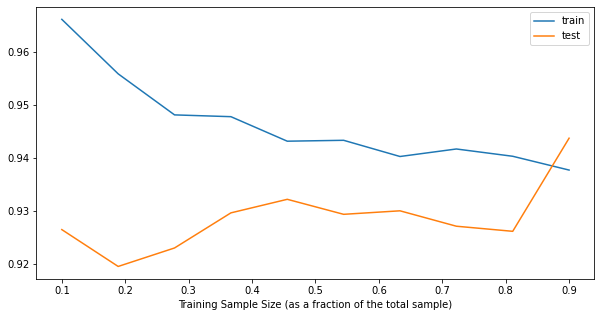

In [39]:
test_acc=[];
train_acc=[];
for k in np.linspace(0.1, 0.9, num=10, endpoint=True):
    X_train, X_test, y_train, y_test = train_test_split(funda[varlist], y, test_size=k, random_state=4000);
    clf = tree.DecisionTreeClassifier(random_state=2, criterion='gini', max_depth=3)
    clf.fit(X_train,y_train);
    train_acc.append(clf.score(X_train, y_train))
    test_acc.append(clf.score(X_test, y_test));
    
fig, ax = plt.subplots(1,1, figsize=(10,5));
plt.plot(1-np.linspace(0.1, 0.9, num=10, endpoint=True), train_acc, label='train')
plt.plot(1-np.linspace(0.1, 0.9, num=10, endpoint=True), test_acc, label='test')
ax.set_xlabel('Training Sample Size (as a fraction of the total sample)')
ax.legend()

In [40]:
clf = tree.DecisionTreeClassifier(random_state=2, criterion='gini')
clf.fit(X_train,y_train)
# fig, ax= plt.subplots(1,1, figsize=(10,20));
clf.score(X_test, y_test)

0.9286786786786787

In [41]:
# fig, ax= plt.subplots(1,1, figsize=(10,20))
# tree.plot_tree(clf)

In [42]:
# path = clf.cost_complexity_pruning_path(X_train, y_train)
# ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [43]:
validate=[];

for train_index, test_index in skf.split(X_train, y_train):

    X_, X_val = X_train.iloc[train_index,:], X_train.iloc[test_index,:];
    y_, y_val = y_train[train_index], y_train[test_index];
    
    clf = tree.DecisionTreeClassifier( random_state=2)
    path = clf.cost_complexity_pruning_path(X_, y_)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    clfs=[];
    for ccp_alpha in ccp_alphas:
        clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
        clf.fit(X_, y_)
        clfs.append(clf);
    score= np.array([clf.score(X_val, y_val) for clf in clfs])
    validate.append([ccp_alphas[np.argmax(score)], np.amax(score)]);
pd.DataFrame(validate, columns=['Alpha','Validation Accuracy'])
    

Alpha  Validation Accuracy
0  0.000000             0.955056
1  0.004520             0.955056
2  0.010946             0.921348
3  0.003429             0.954545
4  0.005526             0.943182

In [44]:
alpha_ = np.mean(np.array(validate), axis=0)
alpha_

array([0.00488419, 0.94583759])

In [45]:
clf = tree.DecisionTreeClassifier(random_state=2, ccp_alpha=alpha_[0]);
clf = clf.fit(X_train, y_train);
print(clf.tree_.max_depth)
fig, ax = plt.subplots(1, 1, figsize=(20,5))
tree.plot_tree(clf)


5


[Text(0.5909090909090909, 0.9166666666666666, 'X[3] <= 7515.81\ngini = 0.164\nsamples = 443\nvalue = [403, 40]'),
 Text(0.36363636363636365, 0.75, 'X[6] <= 13631.009\ngini = 0.067\nsamples = 405\nvalue = [391, 14]'),
 Text(0.18181818181818182, 0.5833333333333334, 'X[6] <= 3150.964\ngini = 0.035\nsamples = 393\nvalue = [386, 7]'),
 Text(0.09090909090909091, 0.4166666666666667, 'gini = 0.006\nsamples = 347\nvalue = [346, 1]'),
 Text(0.2727272727272727, 0.4166666666666667, 'X[5] <= 0.141\ngini = 0.227\nsamples = 46\nvalue = [40, 6]'),
 Text(0.18181818181818182, 0.25, 'gini = 0.0\nsamples = 35\nvalue = [35, 0]'),
 Text(0.36363636363636365, 0.25, 'X[1] <= 0.105\ngini = 0.496\nsamples = 11\nvalue = [5, 6]'),
 Text(0.2727272727272727, 0.08333333333333333, 'gini = 0.245\nsamples = 7\nvalue = [1, 6]'),
 Text(0.45454545454545453, 0.08333333333333333, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.5454545454545454, 0.5833333333333334, 'X[5] <= 0.043\ngini = 0.486\nsamples = 12\nvalue = [5, 7

In [46]:
clf.score(X_train,y_train),clf.score(X_test,y_test)

(0.9751693002257337, 0.918918918918919)

In [47]:
# fig, ax = plt.subplots(1,1, figsize=(8,4))
# ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
# ax.set_xlabel("effective alpha")
# ax.set_ylabel("total impurity of leaves")
# ax.set_title("Total Impurity vs effective alpha for training set")

## Boosted Decision Trees

In [48]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import zero_one_loss, accuracy_score

In [49]:
validate={};
for rate in [0.1, 0.3]:

    clf = GradientBoostingClassifier(n_estimators=50, learning_rate=rate,
        max_depth=3, random_state=10)
    

    temp=np.zeros((5,50))
    i=0;
    for train_index, test_index in skf.split(X_train, y_train):
        
        X_, X_val = X_train.iloc[train_index,:], X_train.iloc[test_index,:];
        y_, y_val = y_train[train_index], y_train[test_index];

        clf.fit(X_, y_)
        for j, y_pred in enumerate(clf.staged_predict(X_val)):
            temp[i,j] =accuracy_score(y_val, y_pred)
        i+=1;
        
    validate['{}'.format(rate)] = np.mean(temp, axis=0)
    
    
fig, ax = plt.subplots(1,1, figsize=(15,5));
    
for key, value in validate.items():
    plt.plot(np.arange(1,51), value, label="learning rate: {}".format(key))
ax.legend()

In [50]:
num=20
clf = GradientBoostingClassifier(n_estimators=num, learning_rate=0.1,
        max_depth=3, random_state=10).fit(X_train, y_train)
clf2 = GradientBoostingClassifier(n_estimators=num, learning_rate=0.3,
        max_depth=3, random_state=10).fit(X_train, y_train)

print(clf.score(X_test, y_test))
print(clf2.score(X_test, y_test))

# test_acc = np.zeros((num,), dtype=np.float64)
# test_acc2 = np.zeros((num,), dtype=np.float64)

# for i, y_pred in enumerate(clf.staged_predict(X_test)):
    
#     test_acc[i] =accuracy_score(y_test, y_pred)

    
# for i, y_pred in enumerate(clf2.staged_predict(X_test)):

#     test_acc2[i] =accuracy_score(y_test, y_pred)

# fig, ax = plt.subplots(1,1, figsize=(15,5))
# plt.plot(np.arange(num), test_acc, label='Learning Rate=0.1')
# plt.plot(np.arange(num), test_acc2, label='Learning Rate=0.3', linestyle='dashed')
# ax.set_xlabel("Iterations")
# ax.set_ylabel("Accuracy")
# ax.legend()

0.9329329329329329
0.9314314314314315


## KNN methods

In [51]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [52]:
crossVal=[]
for k in range(1,6):
    temp=[];
    for train_index, test_index in skf.split(X_train, y_train):
        
        X_, X_val = X_train.iloc[train_index,:], X_train.iloc[test_index,:];
        y_, y_val = y_train[train_index], y_train[test_index];
        neigh = KNN(n_neighbors=k);
        neigh.fit(X_, y_);

        temp.append(neigh.score(X_val, y_val))
    crossVal.append(temp);
cross_val = pd.DataFrame(crossVal, index=range(1,6));
cross_val['average']=cross_val[cross_val.columns.values].apply(lambda x:np.mean(x), axis=1);
cross_val['std']=cross_val[cross_val.columns.values].apply(lambda x:np.std(x), axis=1);
cross_val

0         1         2         3         4   average       std
1  0.932584  0.943820  0.921348  0.909091  0.931818  0.927732  0.010703
2  0.921348  0.921348  0.932584  0.897727  0.943182  0.923238  0.013802
3  0.943820  0.943820  0.921348  0.943182  0.943182  0.939070  0.008093
4  0.932584  0.943820  0.910112  0.943182  0.931818  0.932303  0.011134
5  0.932584  0.955056  0.921348  0.931818  0.943182  0.936798  0.010451

In [53]:
fig, ax = plt.subplots(1,1, figsize=(15, 5));
ax.errorbar(
    x=np.arange(1,6, dtype='int'),
    y=cross_val["average"],
    yerr=cross_val["std"],
)
ax.set_xticks(np.arange(1,6, dtype='int'))

In [54]:
neigh = KNN(n_neighbors=3);
neigh.fit(X_train,y_train);
neigh.score(X_test,y_test)

0.9134134134134134

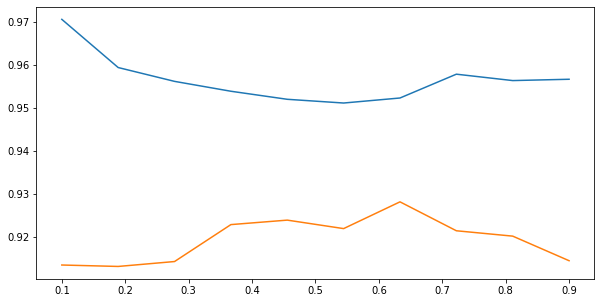

In [55]:
test_acc=[];
train_acc=[];
for k in np.linspace(0.1, 0.9, num=10, endpoint=True):
    X_train, X_test, y_train, y_test = train_test_split(funda[varlist], y, test_size=k, random_state=4000);
    neigh = KNN(n_neighbors=3);
    neigh.fit(X_train, y_train);
    
    train_acc.append(neigh.score(X_train, y_train))
    test_acc.append(neigh.score(X_test, y_test));
    
fig, ax = plt.subplots(1,1, figsize=(10,5));
plt.plot(1-np.linspace(0.1, 0.9, num=10, endpoint=True), train_acc, label='')
plt.plot(1-np.linspace(0.1, 0.9, num=10, endpoint=True), test_acc)

## SVM

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

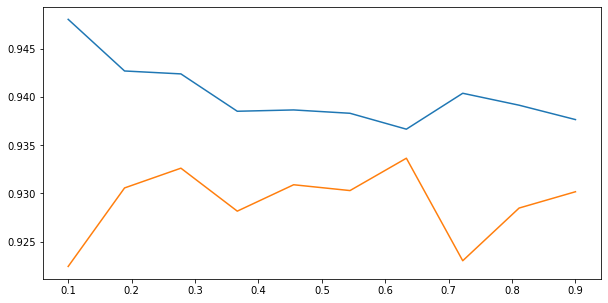

In [57]:
test_acc=[];
train_acc=[];
for k in np.linspace(0.1, 0.9, num=10, endpoint=True):
    X_train, X_test, y_train, y_test = train_test_split(funda[varlist], y, test_size=k, random_state=4000);
    clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma='auto'))
    clf.fit(X_train, y_train)
    clf.score(X_test, y_test)
    train_acc.append(clf.score(X_train, y_train))
    test_acc.append(clf.score(X_test, y_test));
    
fig, ax = plt.subplots(1,1, figsize=(10,5));
plt.plot(1-np.linspace(0.1, 0.9, num=10, endpoint=True), train_acc)
plt.plot(1-np.linspace(0.1, 0.9, num=10, endpoint=True), test_acc)




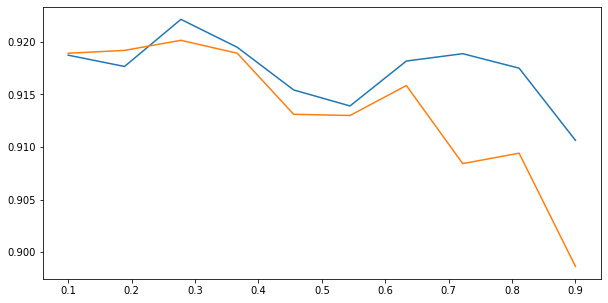

In [58]:
test_acc=[];
train_acc=[];
for k in np.linspace(0.1, 0.9, num=10, endpoint=True):
    X_train, X_test, y_train, y_test = train_test_split(funda[varlist], y, test_size=k, random_state=4000);
    clf = make_pipeline(StandardScaler(), SVC(kernel='sigmoid', gamma='auto'))
    clf.fit(X_train, y_train)
    clf.score(X_test, y_test)
    train_acc.append(clf.score(X_train, y_train))
    test_acc.append(clf.score(X_test, y_test));
    
fig, ax = plt.subplots(1,1, figsize=(10,5));
plt.plot(1-np.linspace(0.1, 0.9, num=10, endpoint=True), train_acc)
plt.plot(1-np.linspace(0.1, 0.9, num=10, endpoint=True), test_acc)


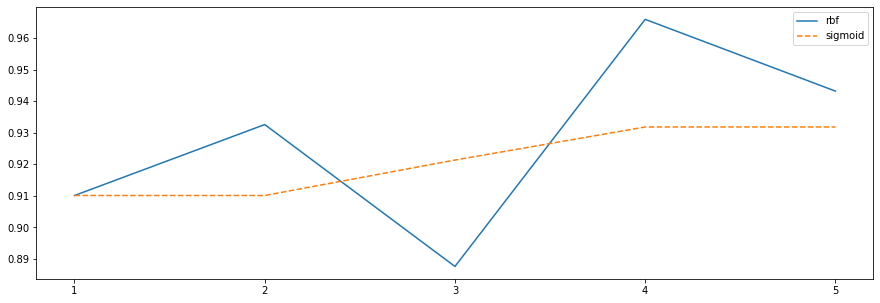

In [59]:
crossVal={}
for method in ['rbf','sigmoid']:
    temp=[];
    for train_index, test_index in skf.split(X_train, y_train):
        
        X_, X_val = X_train.iloc[train_index,:], X_train.iloc[test_index,:];
        y_, y_val = y_train[train_index], y_train[test_index];
        clf = make_pipeline(StandardScaler(), SVC(kernel=method, gamma='auto'))
        clf.fit(X_, y_)
        
        temp.append(clf.score(X_val, y_val))
    crossVal[method]=temp;


fig, ax = plt.subplots(1,1, figsize=(15,5));
plt.plot(np.arange(1,6), crossVal['rbf'], label='rbf')
plt.plot(np.arange(1,6), crossVal['sigmoid'], label='sigmoid', linestyle='dashed')
ax.set_xticks(np.arange(1,6, dtype='int'))
ax.legend()

In [60]:
clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma='auto'))
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9224224224224224

## ANN

In [61]:
import warnings

import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
from sklearn.exceptions import ConvergenceWarning

In [62]:
validate={};
for i in [50, 100, 200]:
    temp=[]
    for train_index, test_index in skf.split(X_train, y_train):
        
        X_, X_val = X_train.iloc[train_index,:], X_train.iloc[test_index,:];
        y_, y_val = y_train[train_index], y_train[test_index];

    
        X_scaled = StandardScaler().fit_transform(X_);
        X_val_scaled = StandardScaler().fit_transform(X_val);
    
        mlp = MLPClassifier(random_state=30, hidden_layer_sizes=i, learning_rate_init= 0.001, max_iter=1000, solver='adam');
        mlp.fit(X_scaled, y_)
        temp.append(mlp.score(X_val_scaled, y_val))

        
    validate['{}'.format(int(i))] = np.mean(np.array(temp), axis=0)
    

validate
    
   





{'50': 0.9346016343207355,
 '100': 0.9436159346271706,
 '200': 0.9368232890704802}

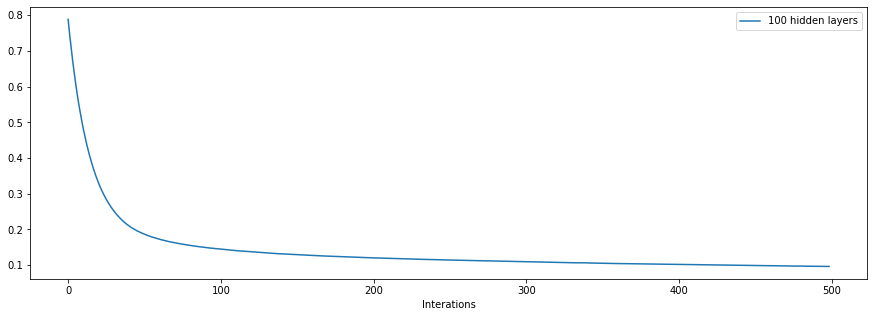

In [63]:
fig, ax= plt.subplots(1,1, figsize=(15,5));
mlp = MLPClassifier(random_state=30, hidden_layer_sizes=100, learning_rate_init= 0.001, max_iter=1000, solver='adam')
X_train_scaled = StandardScaler().fit_transform(X_train);
mlp.fit(X_train_scaled, y_train);
ax.plot(mlp.loss_curve_, label='{} hidden layers'.format(100));
ax.set_xlabel("Interations")
ax.legend()

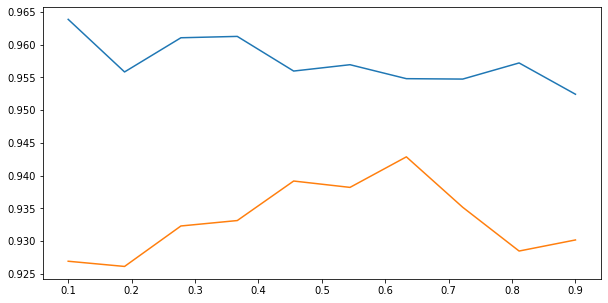

In [64]:
test_acc=[];
train_acc=[];
for k in np.linspace(0.1, 0.9, num=10, endpoint=True):
    X_train, X_test, y_train, y_test = train_test_split(funda[varlist], y, test_size=k, random_state=4000);
    mlp = MLPClassifier(random_state=30, hidden_layer_sizes=100, learning_rate_init= 0.001, max_iter=1000, solver='adam')
    X_train_scaled = StandardScaler().fit_transform(X_train);
    X_test_scaled = StandardScaler().fit_transform(X_test);
    mlp.fit(X_train_scaled, y_train)
    
    train_acc.append(mlp.score(X_train_scaled, y_train))
    test_acc.append(mlp.score(X_test_scaled, y_test));
    
fig, ax = plt.subplots(1,1, figsize=(10,5));
plt.plot(1-np.linspace(0.1, 0.9, num=10, endpoint=True), train_acc)
plt.plot(1-np.linspace(0.1, 0.9, num=10, endpoint=True), test_acc)

In [65]:
X_train_scaled = StandardScaler().fit_transform(X_train);
X_test_scaled = StandardScaler().fit_transform(X_test);
mlp.fit(X_train_scaled, y_train)
mlp.score(X_train_scaled, y_train)

0.963882618510158